In [1]:
import pandas as pd
import numpy as np
import math
import sklearn.datasets
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
import sklearn.tree
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns

##Seaborn for fancy plots. 
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (8,8)

IN_COLAB = 'google.colab' in str(get_ipython())
if IN_COLAB:
    !wget https://raw.githubusercontent.com/AkeemSemper/Intro_to_Machine_Learning_Student_Workbooks/main/data/heart.csv
    df_heart = pd.read_csv("heart.csv")
    !wget https://raw.githubusercontent.com/AkeemSemper/ML_for_Non_DS_Students/main/data/adult_income.csv
    df_income = pd.read_csv("adult_income.csv")
else:
    df_income = pd.read_csv("../data/adult_income.csv")
    df_heart = pd.read_csv("../data/heart.csv")
df_income.rename(columns = {"Income": "target"}, inplace = True)

pair_plot_sample_size = 200
cv_folds = 3

# Classification Trees Revisited

We can continue on with exploring classification trees and add one new feature - regularization. 

#### Note - Accessing Internal Values from ColumnTransformers, Pipelines, and GridSearchCV

Below there are several examples of extracting internal values from models and tools that are embedded in multiple layers of pipes and grids. This is generally easy to do, but annoying, especially the first time you do it. These are documented in the Attributes' section of the documentation page of the function on the sklearn docs page. 

In general, these are the types of things that AI does extremely well - you have to navigate an annoyingly complex structure to get a simple value. You can specify what you want, and the AI will figure out the multiple attributes, indices, and labels needed to track it down. Sklearn is extremely common, and these steps are also common, so all of this will be documented online on sites such as StackOverflow, with code examples that you can adapt by changing a couple of names. Focus your attention on the information you need, then look for a way to extract it. The examples below are one set of examples that you can adapt.

## But First, Exploration

The top part of the notebook setup will be a little different here (the reason being that other parts below use the results, so I wanted to make sure things still work). We are going to do some more in-depth data exploration and prep before creating our models.

### Your Data Exploration

Add as many cells in here as you need to explore and clean the data. 

In [2]:
# Start Exploring
df_income.head()

,Age,Work Class,fnlwgt,Education,Education-num,Marital-Status,Occupation,Relationship,Race,Sex,Capital-gain,Capital-loss,Hours-per-week,Native-country,target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


### My Data Exploration

Try to do yours before scrolling. Remember, this isn't a deterministic process, there isn't one specific correct answer. 

In [3]:
df_income.head()

,Age,Work Class,fnlwgt,Education,Education-num,Marital-Status,Occupation,Relationship,Race,Sex,Capital-gain,Capital-loss,Hours-per-week,Native-country,target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [4]:
df_income.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             32561 non-null  int64 
 1   Work Class      32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   Education       32561 non-null  object
 4   Education-num   32561 non-null  int64 
 5   Marital-Status  32561 non-null  object
 6   Occupation      32561 non-null  object
 7   Relationship    32561 non-null  object
 8   Race            32561 non-null  object
 9   Sex             32561 non-null  object
 10  Capital-gain    32561 non-null  int64 
 11  Capital-loss    32561 non-null  int64 
 12  Hours-per-week  32561 non-null  int64 
 13  Native-country  32561 non-null  object
 14  target          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [5]:
df_income.describe(include = "all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Age,32561.0,NaN,NaN,NaN,38.581647,13.640433,17.0,28.0,37.0,48.0,90.0
Work Class,32561,9,Private,22696,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fnlwgt,32561.0,NaN,NaN,NaN,189778.366512,105549.977697,12285.0,117827.0,178356.0,237051.0,1484705.0
Education,32561,16,HS-grad,10501,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Education-num,32561.0,NaN,NaN,NaN,10.080679,2.57272,1.0,9.0,10.0,12.0,16.0
Marital-Status,32561,7,Married-civ-spouse,14976,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Occupation,32561,15,Prof-specialty,4140,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Relationship,32561,6,Husband,13193,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Race,32561,5,White,27816,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sex,32561,2,Male,21790,NaN,NaN,NaN,NaN,NaN,NaN,NaN


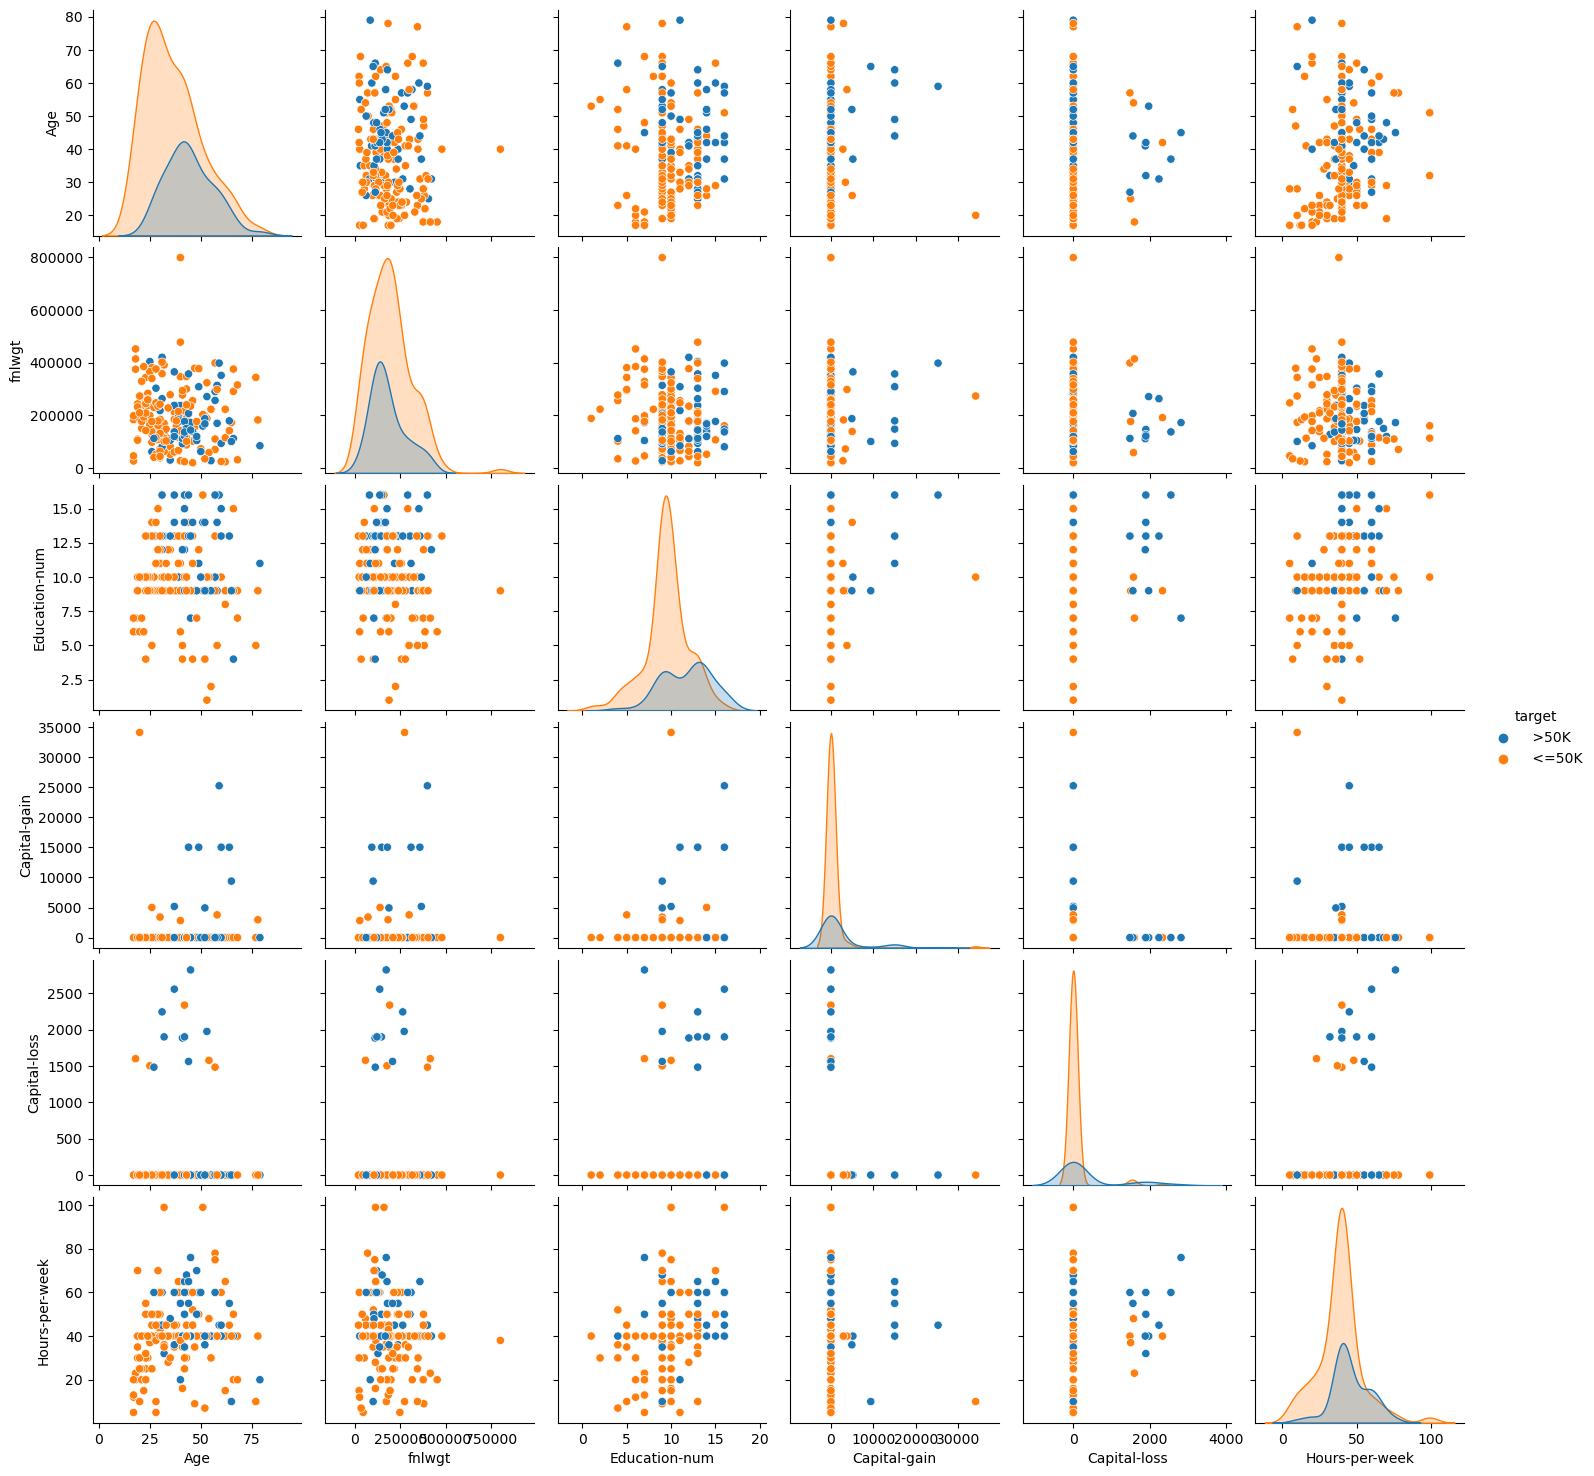

In [6]:
sns.pairplot(df_income.sample(pair_plot_sample_size), hue = "target")

##### Categorical Data

We have a few categorical columns, and we need to decide how to handle them. With a classification task, meaning a categorical target, the countplot is likely the easiest way to visualize the data.

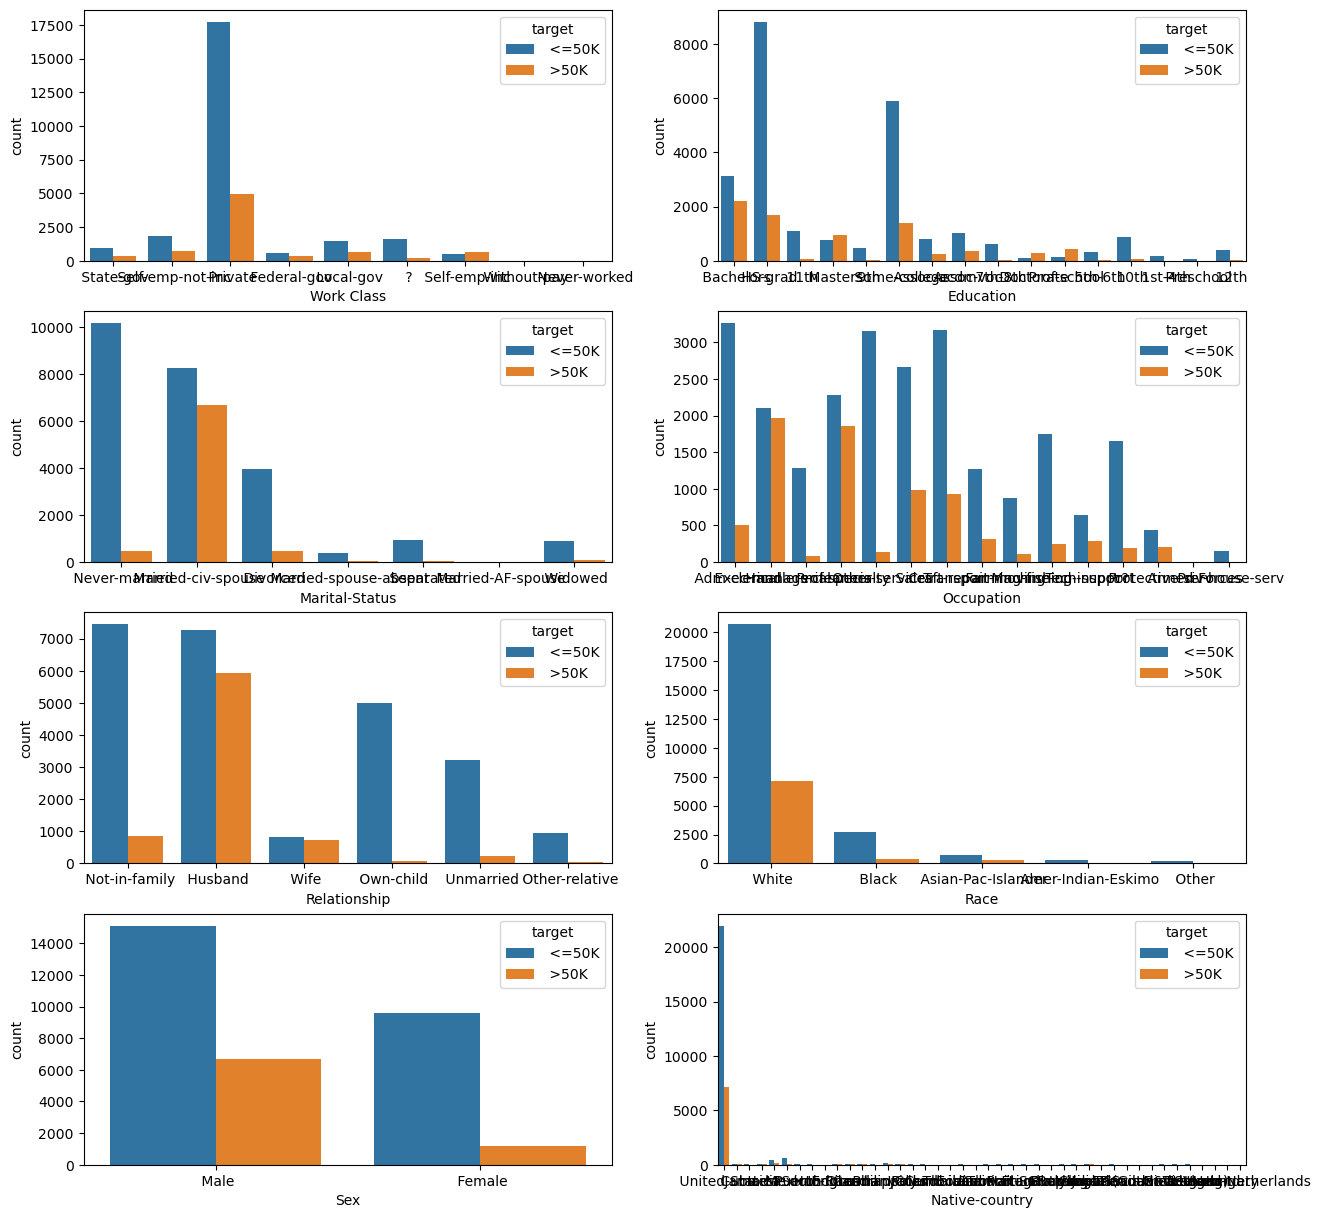

In [7]:
cat_cols = df_income.select_dtypes(include = "object").columns.drop("target")
num_cols = df_income.select_dtypes(exclude = "object").columns
cols = 2
rows = math.ceil(len(cat_cols) / cols)
fig, ax = plt.subplots(rows, cols, figsize = (15, 15))

for val in cat_cols:
    sns.countplot(data = df_income, x = val, hue = "target", ax = ax[cat_cols.get_loc(val) // cols, cat_cols.get_loc(val) % cols])

### Cleaning the Data

We need to do some cleanup here. I'm going to remove outliers and then look again at the data.

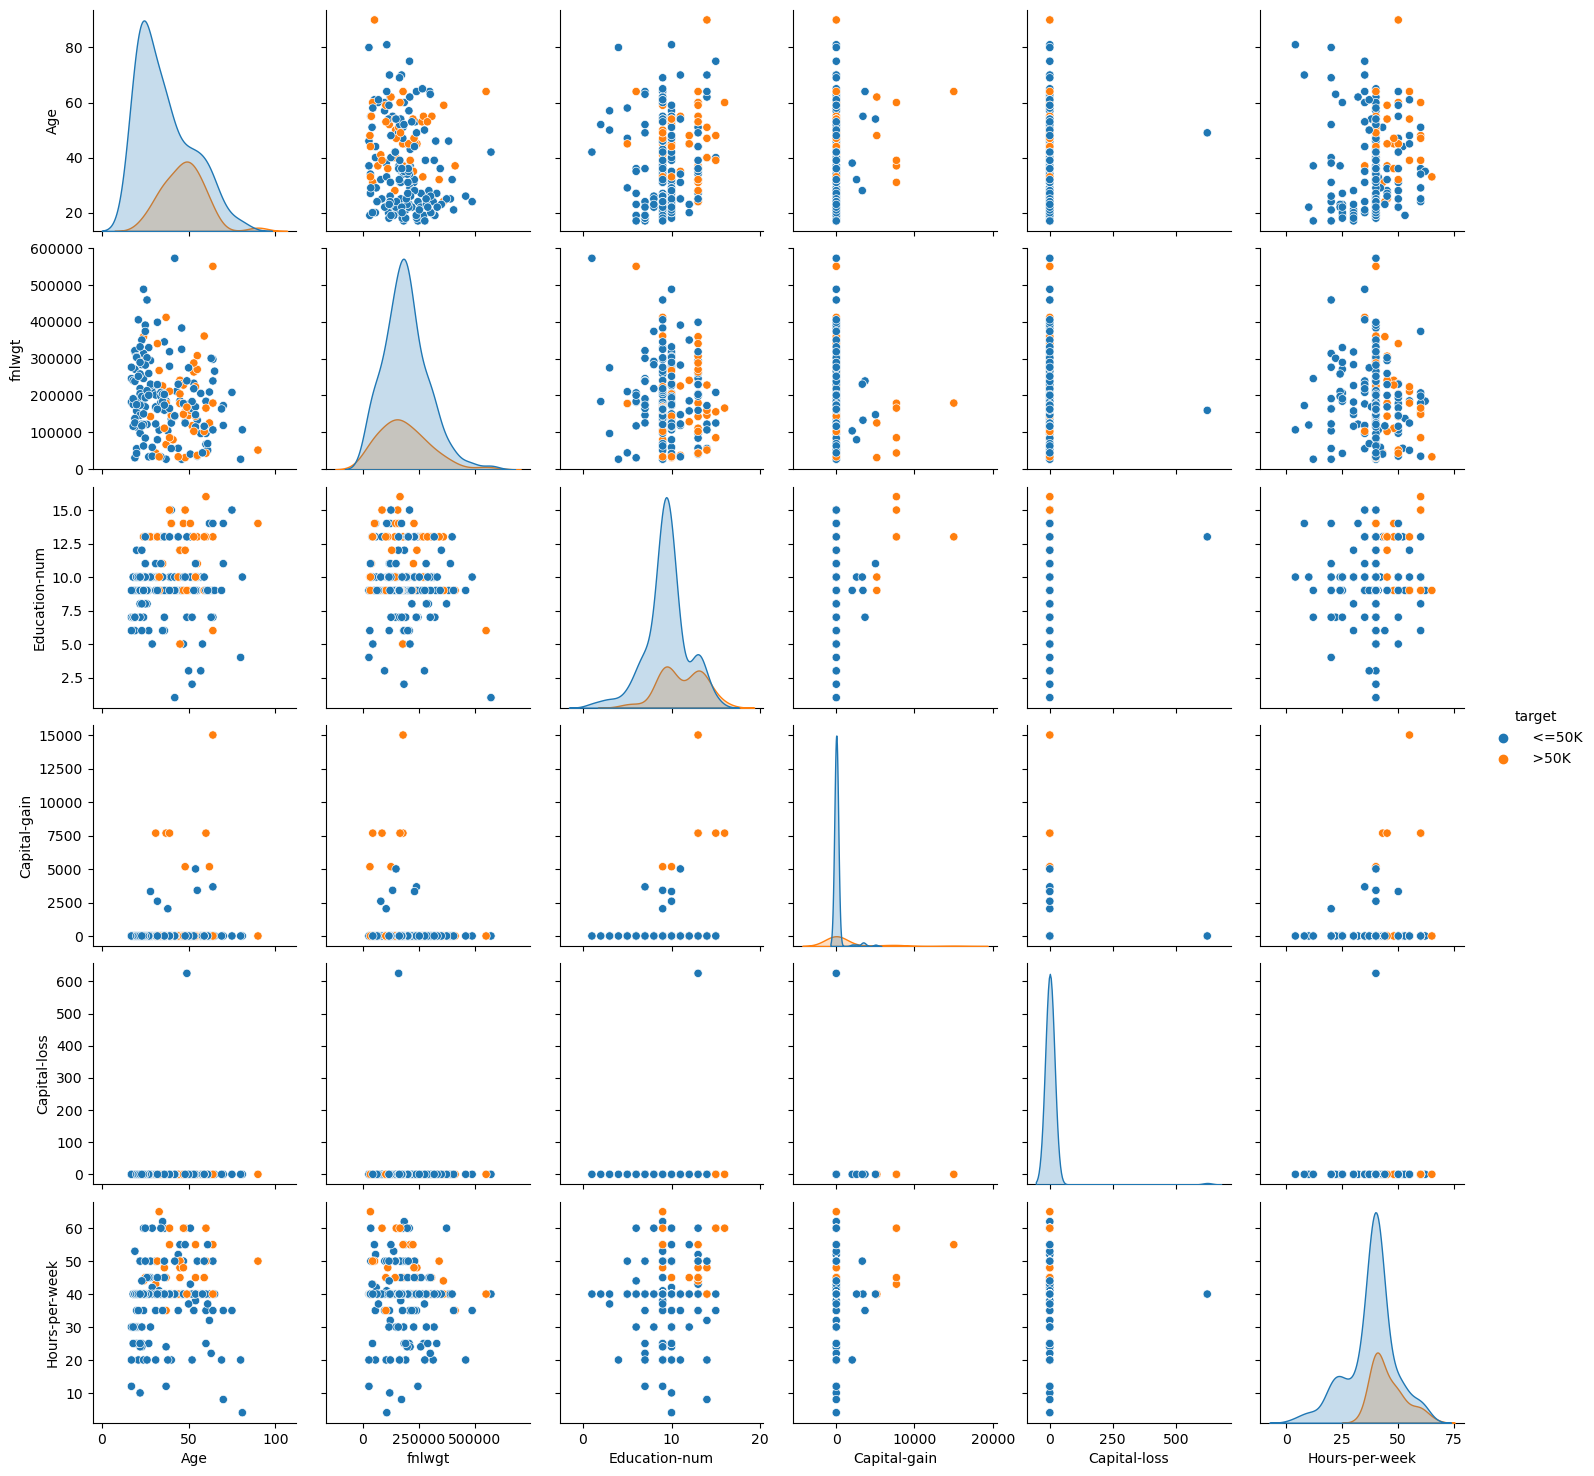

In [8]:
df_income_cleaned = df_income.copy()
df_income_cleaned.drop(columns = ["Native-country"], inplace = True)
df_income_cleaned = df_income_cleaned[ df_income_cleaned["Capital-gain"] < 50000]
df_income_cleaned = df_income_cleaned[ df_income_cleaned["Capital-loss"] < 1000]
df_income_cleaned = df_income_cleaned[ df_income_cleaned["Hours-per-week"] < 70]
sns.pairplot(df_income_cleaned.sample(pair_plot_sample_size), hue = "target")

### Clean Again

After the first round of cleanup, we can dial things in a little more. In particular, I am going to try to make capital gains into a yes/no. Capital loss also doesn't vary at all, so that's not going to be all that helpful in making a prediction.

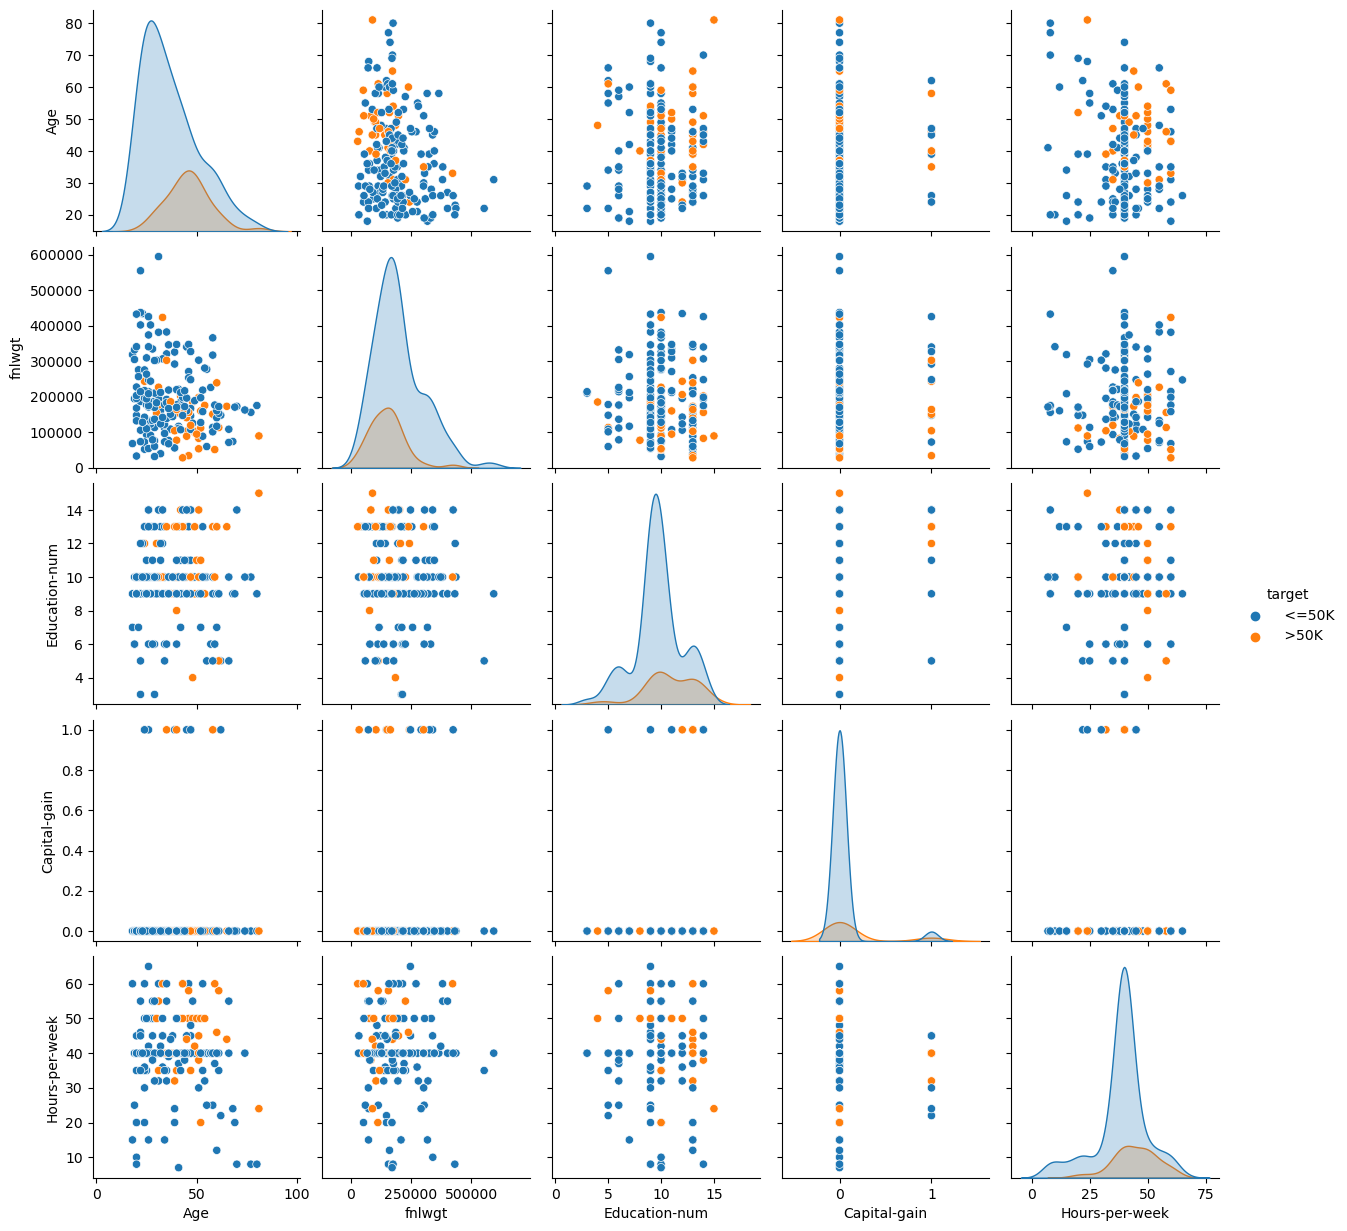

In [9]:
df_income_cleaned.drop(columns = ["Capital-loss"], inplace = True)
df_income_cleaned["Capital-gain"] = [0 if x == 0 else 1 for x in df_income_cleaned["Capital-gain"]]
df_income_cleaned["Capital-gain"] = df_income_cleaned["Capital-gain"].astype("object")
sns.pairplot(df_income_cleaned.sample(pair_plot_sample_size), hue = "target")

### Post-Cleaning

This data is now ready for analysis. Things look to be pretty clean, at least clean enough to get started. If we were doing this for real, at this point we'd probably want to look at the same charts and metrics, mainly the pairplot, with all the data, or at least a larger sample. The sample size I used for the pairplot was tiny, as it is slow to run. 

### Your Modelling

In [10]:
# Make models

### My Modelling

#### Used Pipes

I'm going to compare the Logistic Regression model with the Decision Tree model, and we can use pipes to make this easier. The initial data prep for either model will be the same, so I can reuse those pipes in either place. 

In [11]:
inc_cat_cols = df_income_cleaned.select_dtypes(include = "object").columns.drop("target")
inc_num_cols = df_income_cleaned.select_dtypes(exclude = "object").columns

inc_y = df_income_cleaned["target"]
inc_X = df_income_cleaned.drop(columns = "target")

inc_num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy = "mean")),
    ("scaler", MinMaxScaler())
])
inc_cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy = "most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown = "ignore"))
])
inc_ct = ColumnTransformer([
    ("num", inc_num_pipe, inc_num_cols),
    ("cat", inc_cat_pipe, inc_cat_cols)
])
inc_LR_grid = {
    "model__C": np.logspace(-3, 3, 12),
    "model__penalty": ["l1", "l2"],
}
inc_LR_pipe = Pipeline([
    ("ct", inc_ct),
    ("model", LogisticRegression(max_iter=1000))
])

inc_DT_grid = {
    "model__max_depth": np.arange(1, 6),
    "model__min_samples_split": np.arange(3, 10),
    "model__min_samples_leaf": np.arange(3, 10)
}
inc_CT_pipe = Pipeline([
    ("ct", inc_ct),
    ("model", DecisionTreeClassifier())
])

In [12]:
import warnings
warnings.filterwarnings("ignore")

In [13]:
inc_LR_grid = GridSearchCV(inc_LR_pipe, inc_LR_grid, cv = cv_folds, n_jobs = -1, return_train_score=True)
inc_DT_grid = GridSearchCV(inc_CT_pipe, inc_DT_grid, cv = cv_folds, n_jobs = -1, return_train_score=True)

inc_LR_grid.fit(inc_X, inc_y)
inc_DT_grid.fit(inc_X, inc_y)

inc_LR_preds = inc_LR_grid.predict(inc_X)
inc_DT_preds = inc_DT_grid.predict(inc_X)

print("Results:")
print("Logistic Regression:")
print("Best params: ", inc_LR_grid.best_params_)
print("CV score: ", inc_LR_grid.best_score_)

print("Decision Tree:")
print("Best params: ", inc_DT_grid.best_params_)
print("CV score: ", inc_DT_grid.best_score_)

Results:
Logistic Regression:
Best params:  {'model__C': 0.1519911082952933, 'model__penalty': 'l2'}
CV score:  0.8494172408123936
Decision Tree:
Best params:  {'model__max_depth': 5, 'model__min_samples_leaf': 8, 'model__min_samples_split': 3}
CV score:  0.8387205562676959


### Results and Comparison

Text(0.5, 1.0, 'Decision Tree')

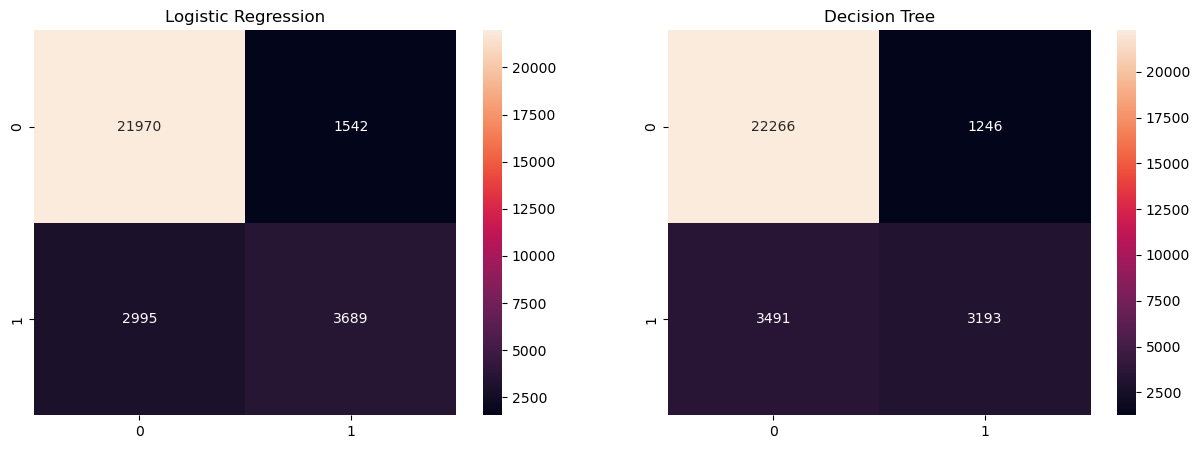

In [14]:
fig, ax = plt.subplots(1, 2, figsize = (15, 5))
sns.heatmap(confusion_matrix(inc_y, inc_LR_preds), annot = True, fmt = "d", ax = ax[0])
sns.heatmap(confusion_matrix(inc_y, inc_DT_preds), annot = True, fmt = "d", ax = ax[1])
ax[0].set_title("Logistic Regression")
ax[1].set_title("Decision Tree")

## Tuning Trees, Part 2


### Tune it Like a Lumberjack

This is a very quick and dirty way to get a smaller, reasonably tuned tree model without a massive amount of effort. There are a few steps, but they are all pretty simple.
<ul>
<li> Allow a tree model to overfit. </li>
<li> Observe the feature importance of the model, and generate a subset of the ones that have substantially higher importance. </li>
<li> Use the subset of features to build a new tree model. </li>
<li> Do a grid search on the sizing details for this new, smaller model. </li>
</ul>

This has the effect of forcing the tree to only use the "most important stuff", which tends to help fight overfitting because things that are less significant that could be used to divide the data whilst overfitting are not available to the model. The grid search with the smaller dataset will find the best arrangement of the tree under these constraints. 

<b>Note:</b> This isn't a perfect method to make a great model every time, but it will often yield a pretty good estimate of what a good model might look like.

### Linear Importance

In addition to the nice feature importance scores from the tree model, we can also look at the coefficients from the logistic regression model. Remember that a prediction from a regression model is just the sum of the product of the coefficients and the features. This means that the coefficients are a measure of how important a feature is in the model. 

$ y = m1*x1 + m2*x2 + m3*x3 + ... + mn*xn $

The larger the coefficient, or weight, the more that feature contributes to the prediction.

#### Outside Influence

One thing that we are doing here is that we are allowing our models to inform each other, Each type of model does the same thing, but in a totally different way behind the scenes. We can, and sometimes do, have models where one type heavily uses a feature that another mostly ignores. If we use the relative importance of the features for the two varieties of models we have available to us, we can start to compile some information on what matters more and what matters less. Neither of these lists are conclusive, but we can look for patterns in the two lists to see what features are likely to be more important. One key note, these lists will give us the actual features the model saw - meaning that if a categorical feature has been one-hot encoded, we may only get one of the one-hot encoded features as important. In this example, I am using the most simple way to interpret that - I'll keep the entire category. There are other choice though, one being to turn the one-hot encoded features that matter into yes/no - either it is the thing that we included, or not. For example, if hair color was a categorical feature, and we found that hair_color-blonde was important in these lists of important features, we could transform that original data into a boolean of "is_blonde" and "is_not_blonde". This would allow us to keep the information that blonde hair is important, but not the information that the other hair colors are not important. Things like this are a design choice, and something we'd likely do as we are trying to refine our model after a step like this. Like with most things, guess and test is the best way to figure out what works best for your data.

For this one, Education, Marital Status, Capital Gain, and Age tend to be towards the top. This does vary though, especially for the tree as we noted that it is unstable and we might get totally different results if we ran it again. As data sizes get larger, this will tend to stabilize, but it is still a good idea to run the model a few times to see if the results are consistent. Maybe there are ways to make this more automatic...

In [15]:
inc_LR_feature_importance = inc_LR_grid.best_estimator_.named_steps["model"].coef_
inc_LR_feature_importance = pd.Series(inc_LR_feature_importance[0], index = inc_num_cols.tolist() + inc_LR_grid.best_estimator_.named_steps["ct"].named_transformers_["cat"].named_steps["encoder"].get_feature_names_out(inc_cat_cols).tolist())
inc_LR_imp = inc_LR_feature_importance.sort_values(ascending = False)
inc_LR_imp = inc_LR_imp[0:6]
inc_LR_imp

Hours-per-week                        2.539948
Education-num                         2.113519
Age                                   1.875654
Marital-Status_ Married-civ-spouse    1.359958
Relationship_ Wife                    1.312508
Education_ Prof-school                0.963873
dtype: float64

In [16]:
inc_CT_feature_importance = inc_DT_grid.best_estimator_.named_steps["model"].feature_importances_
inc_CT_feature_importance = pd.Series(inc_CT_feature_importance, index = inc_num_cols.tolist() + inc_DT_grid.best_estimator_.named_steps["ct"].transformers_[1][1].named_steps["encoder"].get_feature_names_out(inc_cat_cols).tolist())
inc_CT_imp = inc_CT_feature_importance[inc_CT_feature_importance > .05].sort_values(ascending = False)
inc_CT_imp

Marital-Status_ Married-civ-spouse    0.520950
Education-num                         0.281812
Capital-gain_0                        0.085766
dtype: float64

In [17]:
inc_limit_cols = ["Age", "Education", "Marital-Status"]
inc_small_X = inc_X[inc_limit_cols]
inc_small_num_cols = inc_small_X.select_dtypes(exclude = "object").columns
inc_small_cat_cols = inc_small_X.select_dtypes(include = "object").columns

inc_small_CT = ColumnTransformer([
    ("num", inc_num_pipe, inc_small_num_cols),
    ("cat", inc_cat_pipe, inc_small_cat_cols)
])
inc_small_LR_pipe = Pipeline([
    ("ct", inc_small_CT),
    ("model", LogisticRegression(max_iter=1000))
])
inc_small_CT_pipe = Pipeline([
    ("ct", inc_small_CT),
    ("model", DecisionTreeClassifier())
])

inc_small_LR_grid = GridSearchCV(inc_small_LR_pipe, inc_LR_grid.param_grid, cv = cv_folds, n_jobs = -1, return_train_score=True)
inc_small_DT_grid = GridSearchCV(inc_small_CT_pipe, inc_DT_grid.param_grid, cv = cv_folds, n_jobs = -1, return_train_score=True)

inc_small_LR_grid.fit(inc_small_X, inc_y)
inc_small_DT_grid.fit(inc_small_X, inc_y)

inc_small_LR_preds = inc_small_LR_grid.predict(inc_small_X)
inc_small_DT_preds = inc_small_DT_grid.predict(inc_small_X)

print("Results:")
print("Logistic Regression:")
print("Best params: ", inc_small_LR_grid.best_params_)
print("CV score: ", inc_small_LR_grid.best_score_)
print("Decision Tree:")
print("Best params: ", inc_small_DT_grid.best_params_)
print("CV score: ", inc_small_DT_grid.best_score_)

Results:
Logistic Regression:
Best params:  {'model__C': 0.012328467394420659, 'model__penalty': 'l2'}
CV score:  0.8272951755703302
Decision Tree:
Best params:  {'model__max_depth': 5, 'model__min_samples_leaf': 5, 'model__min_samples_split': 3}
CV score:  0.8244802090603409


Text(0.5, 1.0, 'Decision Tree')

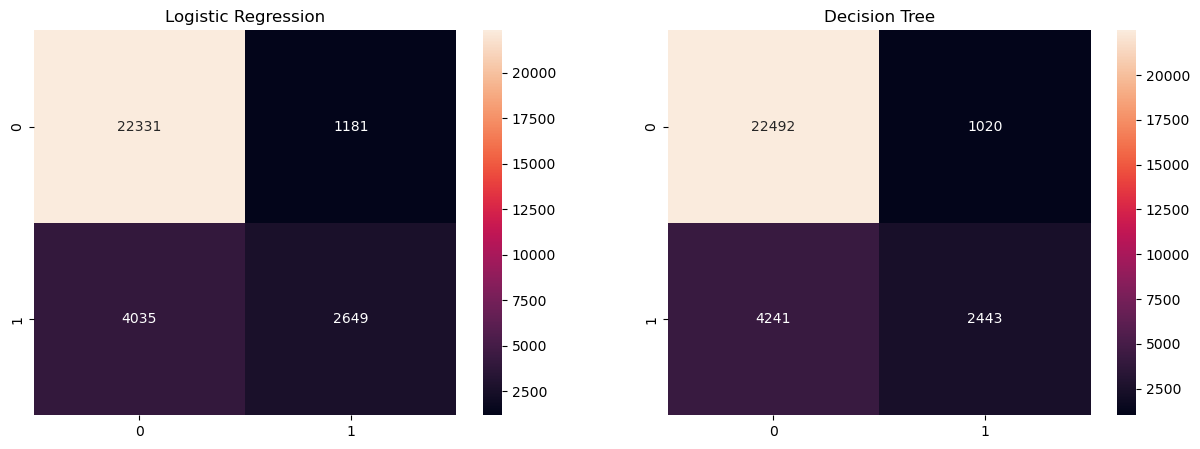

In [18]:
fig, ax = plt.subplots(1, 2, figsize = (15, 5))
sns.heatmap(confusion_matrix(inc_y, inc_small_LR_preds), annot = True, fmt = "d", ax = ax[0])
sns.heatmap(confusion_matrix(inc_y, inc_small_DT_preds), annot = True, fmt = "d", ax = ax[1])
ax[0].set_title("Logistic Regression")
ax[1].set_title("Decision Tree")

## Regularization

Another technique that can be used to tune our tree models is called regularization, which is another technique to prevent overfitting. Regularization is a very common technique that is seen often in commonly used models such as linear regression, logistic regression, and neural networks. The core concept of regularization is relatively simple, we add a penalty term to the cost (error) that penalizes additional complexity - in the case of trees, this is the number of size of the tree.

### Cost Optimization

If you recall the process of gradient descent, the process attempts to minimize the cost, or a measurement of total error. Each function has some type of cost function that measures how good that model is:
<ul>
<li> Regression - usually Mean Squared Error (MSE) </li>
<li> Classification - usually Cross-Entropy. In our 2 way classification, this is called binary cross-entropy or log-loss. </li>
</ul>

The details of this cost function aren't important here, all that matters is that:
<ul>
<li> The value of the cost function tells us how good our model is. </li>
<li> We want to minimize the cost function. </li>
<li> The ideal model will be the one with the lowest cost. </li>
</ul>

The key difference here is that whatever algorithm is training the model (like gradient descent or the tree algorithm) is no longer attempting to minimize the cost, it is not attempting to minimize the combination of (cost + size_penalty). This is the core concept of regularization - our model's cost gets lower if we make it more accurate or smaller; our model's cost gets higher if we make it more complex or make more mistakes. 

#### Penalty Term

The penalty term is the one thing that changes when we utilize regularization, we change the cost function from being, <i>"A function that measures the total error"</i> to being, <i>"A function that measures the total error + a penalty for model size"</i>.The penalty term is usually a function of the size of the model, in the case of trees, we can use the number of nodes, the depth of the tree, or the number of leaves as a proxy for the size of the model. In practice, the technique used in trees is called pruning, or more specifically, Cost Complexity Pruning (CCP). The idea is to add a penalty term to the cost function that penalizes the size of the tree. The penalty term is called alpha, and the new cost function is called the cost complexity function. The cost complexity function is defined as:

$ R_\alpha(T) = R(T) + \alpha|\widetilde{T}| $

Where:

$ R(T) $ is the misclassification rate of the tree. 

$ |\widetilde{T}| $ is the number of terminal nodes. 

$ \alpha $ is a parameter that controls the strength of the pruning. 

If you look at a single node (T = 1), then the formula is:

$ R_\alpha(t)=R(t)+\alpha $

So alpha is the value needed to raise the cost complexity of the node (right side of the equation) to match the cost complexity of the branch (left side). Ideally we want the branches to reduce our impurity - we want the branches to have a lower amount of misclassification. The pruning algoritm picks off the nodes with the lowest alpha, or those that are least improved by splitting, until that alpha value reaches whatever limit is specified. As nodes are killed off, the tree gets smaller and less deep, the end result being the same as if we limited it via a hyperparamater. 

Put in other words, the $ \alpha|\widetilde{T}| $ part is a penalty imposed that increases the more terminal nodes there are, so for a split to occur it must not only make the two resulting nodes more pure, it must do so "enough" to overcome this additional penalization. The higher alpha is, the higher the bar is for a split to be kept. 

We can use some sklearn demo stuff to illustrate the differences with different alpha levels, and thus different 'aggressiveness' of pruning. This demonstrates the idea of managing accuracy in the training set vs the testing set to combat overfitting, something that will come up regularly. Here we are purposefully limiting how accurate the model can get during training in order to ensure it does not become overfitted. 

### CCP Alpha and Pruning

Using pruning and the cost complexity function, we can now tune our tree models by changing the value of hyperparameter alpha. The value of alpha determines how much we penalize the size of the tree. If alpha is 0, then we are not penalizing the size of the tree at all, and the tree will be as large as possible. If alpha is very large, then we are penalizing the size of the tree a lot, and the tree will be very small. The value of alpha is a hyperparameter that we can tune, and we can use cross-validation to find the best value of alpha. In this sense, we can treat this regularization technique as a hyperparameter that we can tune to prevent overfitting, so we don't need to deeply understand the math behind it to use it!

When using pruning in our trees, we are accomplishing the same thing as we did with normal hyperparameter tuning, we are just allowing this algorithm to dynamically determine the size limits on the tree rather than specifying each possibility in a grid. The resulting tree that we get using regularization can be the same or similar as what we'd get if we did a really large grid search. 

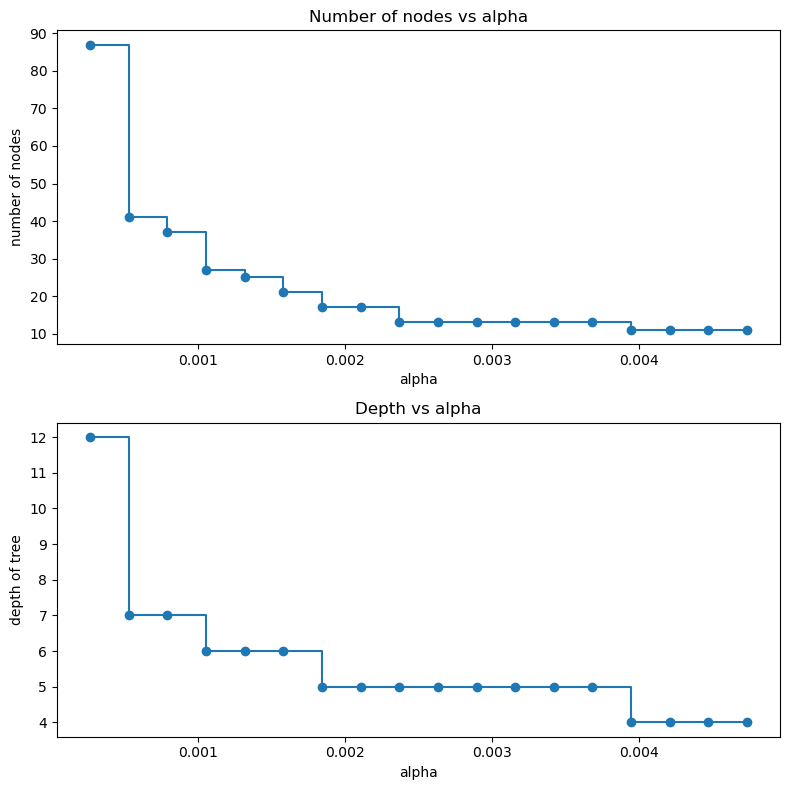

In [52]:
offset = 1
front_offset = 1
X_inc_dummies = pd.get_dummies(inc_X)
ccp_alphas = np.linspace(0, 0.005, 20)
#X_train, X_test, y_train, y_test = train_test_split(X_inc_dummies, inc_y, random_state = 0)
X_inc_train, X_inc_test, y_inc_train, y_inc_test = train_test_split(X_inc_dummies, inc_y, random_state = 0)
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_inc_train, y_inc_train)
    clfs.append(clf)

clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]
impurities = [clf.tree_.impurity[0] for clf in clfs]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas[front_offset:], node_counts[front_offset:], marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas[front_offset:], depth[front_offset:], marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

### Regularization Applications

Regularization is one of the most common techniques to use to combat overfitting, for several reasons:
<ul>
<li> It is relatively simple to understand and explain. </li>
<li> It is easy to implement, generally just by adding a hyperparameter to the model. </li>
<li> It is often effective at preventing overfitting. </li>
<li> There isn't another step or manual work required, we can build it into our process. </li>
<li> We don't need to deeply examine the specifics of the data or model, as we would if we were doing something like removing a feature. The regularization will automatically adjust. </li>
<li> There isn't (usually) a large speed or efficieny cost to using regularization, at least in smaller examples. </li>
</ul>

So we can add regularization to almost any model that uses an iterative process to minimize a cost function, which includes the tree building algorithm and gradient descent, which is used in many model types. 

#### Pruning Results

In the chart above, the more alpha we allow, the more pruning is done, the less tailored to the data the model is allowed to become during training. We can also look at the size of the resulting tree - the more pruning, the smaller the tree. There is a reasonable chance that a good alpha is somewhere around where the curve bends, but we can also use cross-validation to find the best alpha with a grid search.

### Alpha Changes

The alpha value acts as a limiter, we can see in the graphs above, the higher alpha gets the more simple the tree is forced to become - less depth and fewer nodes. The impact is the same as if we were to use the HP to set limits here. In effect, a higher alpha sets more strict growth limits on the tree, not allowing it to get large and potentially overfitted. A lower alpha allows the tree to adapt more to the training data, and gives the risk of overfitting. 

We can see this clearly by looking at accuracy on a graph of both the training and testing data at a bunch of different alpha levels; our goal is to get a model with is accurate at making predictions on new data, things that we've never seen before, and that accuracy is best approximated by our testing accuracy. The model learns on training data, then we evaluate it on the testing data. Our "best" model will generally be where the testing accuracy is best - the model has learned from the training data, but hasn't become too fitted to those specific records - on our accuracy charts we often end up with something that fits that pattern, the testing accuracy gets better for a while as we allow the model to "learn" more and become more fitted, then at some point the testing accuracy starts to get worse as the model starts to "memorize" the training data as it overfits. The best model is where that testing accuracy was at its peak. 

In [53]:
train_scores = [clf.score(X_inc_train, y_inc_train) for clf in clfs]
test_scores = [clf.score(X_inc_test, y_inc_test) for clf in clfs]

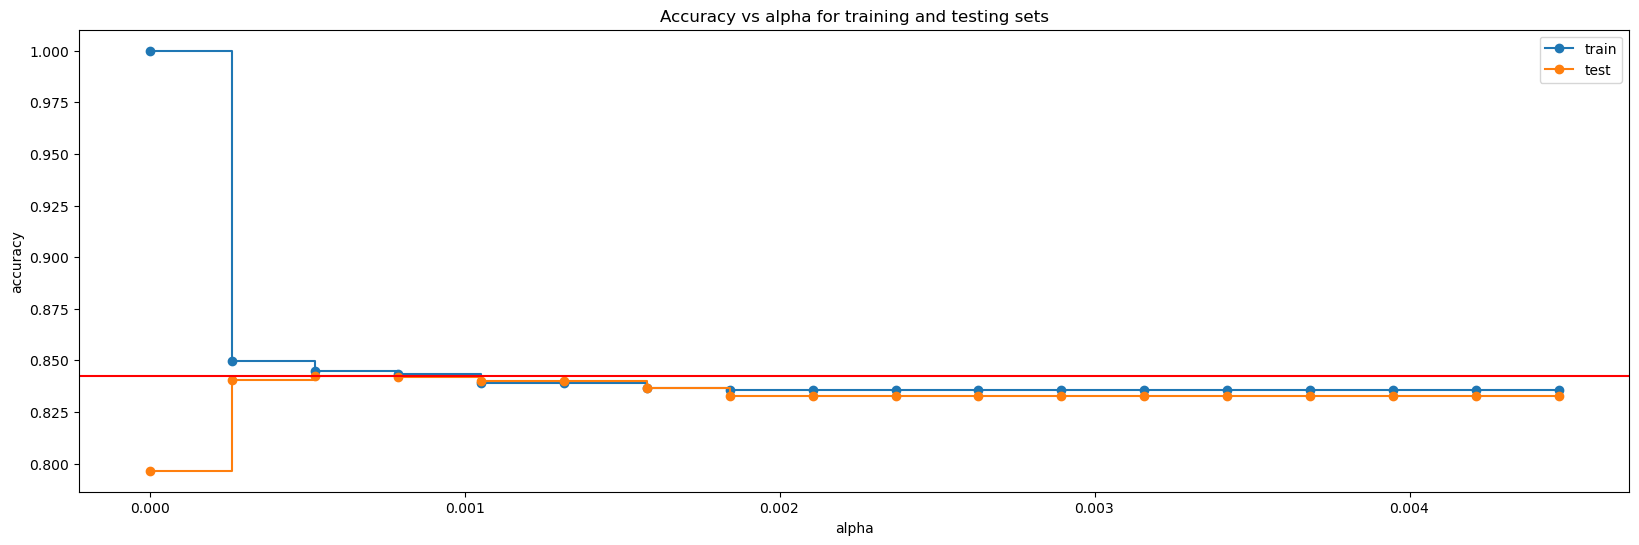

In [58]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas[:-offset], train_scores[:-offset], marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas[:-offset], test_scores[:-offset], marker="o", label="test", drawstyle="steps-post")
ax.axhline(max(test_scores), linestyle="-", color="red")
ax.legend()
plt.show()

## Exercise

Predict the target. Use regularization via the cost complexity pruning method to tune the model. If you have time, compare the results to the non-regularized model, a HP tuned model, and a logistic regression model.

In [55]:
from sklearn.datasets import make_classification
X_ex1, y_ex1 = make_classification(n_samples=10000, n_features=90, n_clusters_per_class=2, random_state=42, scale=9, n_informative=62)
df_ex = pd.DataFrame([y_ex1] + [X_ex1[:,i] for i in range(X_ex1.shape[1])]).T
df_ex.columns = ["target"] + [f"feature_{i}" for i in range(X_ex1.shape[1])]
df_ex.head()

,target,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_80,feature_81,feature_82,feature_83,feature_84,feature_85,feature_86,feature_87,feature_88,feature_89
0,0.0,13.163698,6.001175,30.312262,16.836105,6.893173,-7.690024,0.187259,29.377713,-2.173736,...,88.308148,39.646633,-41.579475,-82.171344,-1.890769,0.411626,-15.471122,-13.419113,10.269971,-33.299851
1,0.0,-91.182861,-3.380321,0.302169,-20.476761,82.193442,2.340783,-21.047910,-40.835112,2.092573,...,-11.417308,-37.312580,14.702235,25.649696,5.051012,1.355835,4.449218,52.323714,-0.311939,-35.817651
2,1.0,27.278072,-11.729580,4.012385,-58.244166,50.196681,5.432447,-7.025220,-22.323895,-10.486036,...,32.731129,39.021813,-23.284505,-38.056722,42.744632,13.306203,81.656892,12.919374,11.429607,64.954301
3,1.0,36.270043,12.800067,-41.690111,-44.863590,-39.903493,5.745910,3.542815,-25.465152,1.153787,...,41.095100,8.107843,-30.840090,-7.904157,53.238845,-9.277539,18.852124,42.890180,-3.878156,21.985967
4,0.0,12.630868,-4.682257,53.125427,-17.452354,-38.444692,5.816587,1.784440,16.877974,-2.095577,...,-0.201657,-31.950293,10.515793,-31.120305,75.044801,7.909865,-44.288434,-7.117989,-13.466574,-16.219735


In [56]:
X_train_ex, X_test_ex, y_train_ex, y_test_ex = train_test_split(df_ex.drop(columns = "target"), df_ex["target"], random_state = 0)

ex_pipe = Pipeline([
    ("scaler", MinMaxScaler()),
    ("model", DecisionTreeClassifier())
])

ex_grid = {
    "model__ccp_alpha": np.logspace(-15, 3, 20)
}

ex_grid = GridSearchCV(ex_pipe, ex_grid, cv = cv_folds, n_jobs = -1, return_train_score=True)
ex_grid.fit(X_train_ex, y_train_ex)

ex_best_model = ex_grid.best_estimator_

print("Best Params: ", ex_grid.best_params_)
print("Model Params: ", ex_best_model.get_params())
print("Best CV Score: ", ex_grid.best_score_)

Best Params:  {'model__ccp_alpha': 0.00206913808111479}
Model Params:  {'memory': None, 'steps': [('scaler', MinMaxScaler()), ('model', DecisionTreeClassifier(ccp_alpha=0.00206913808111479))], 'verbose': False, 'scaler': MinMaxScaler(), 'model': DecisionTreeClassifier(ccp_alpha=0.00206913808111479), 'scaler__clip': False, 'scaler__copy': True, 'scaler__feature_range': (0, 1), 'model__ccp_alpha': 0.00206913808111479, 'model__class_weight': None, 'model__criterion': 'gini', 'model__max_depth': None, 'model__max_features': None, 'model__max_leaf_nodes': None, 'model__min_impurity_decrease': 0.0, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__min_weight_fraction_leaf': 0.0, 'model__random_state': None, 'model__splitter': 'best'}
Best CV Score:  0.7000000000000001


Test Score:  0.7016


Text(0.5, 1.0, 'Confusion Matrix of Test Scores')

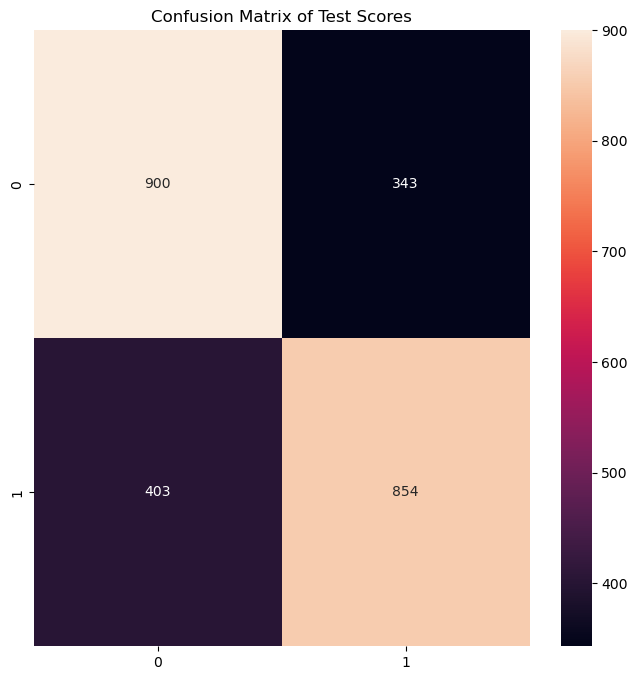

In [57]:
sns.heatmap(confusion_matrix(y_test_ex, ex_best_model.predict(X_test_ex)), annot = True, fmt = "d")
print("Test Score: ", ex_best_model.score(X_test_ex, y_test_ex))
plt.title("Confusion Matrix of Test Scores")